#**RNN & CNN Overview**
This notebook predicts self-propelled particles with a basic RNN and CNN to serve as the deep learning baselines. RNNs and CNNs have both previously been employed to tackle temporal/time-series data and in this notebook we see that they have performed rather exceptionally for certain types of training methodologies. The performance is measured through several different means: (1) visual inspection of the predicted swarm behavior through an animation (2) visual inspection of the predicted and actual swarm behavior on the same plot and (3) inspection of the Mean Field Error.

# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation
import matplotlib
import time
import sys
import math
from matplotlib import animation, rc, rcParams
from IPython.display import HTML
import time
import csv
from IPython.display import display
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data

We create the custom datasets and dataloaders for the swarm data here by reading the csv files

Note that all data and models, datasets are inside the google drive folder.


In [0]:
def load_dataframe(file_path):
  df = pd.read_csv(file_path, header=None)
  all_cols = df.select_dtypes(['object'])
  df_ = df.applymap(lambda x: x.strip('[]').split() if isinstance(x, str) else x)
  df_final = df_.applymap(lambda x: list(map(float, x)))
  return df_final

file_name = '/content/drive/My Drive/Final Project/Datasets/self_propelled_particles/swarm_03162020_noiseless.csv' 
df_final = load_dataframe(file_name)

ss_data = '/content/drive/My Drive/Final Project/Datasets/self_propelled_particles/swarm_03242020_3000steps.csv'
df_ss = load_dataframe(ss_data)

In [0]:
def split_data(df_final, timesteps=3000, num_agents=32):
  ### reads and splits dataframe into position and velocites in np array
  pos_data = np.zeros((timesteps, num_agents, 2))
  vel_data = np.zeros((timesteps, num_agents, 2))
  for i, x in df_final.iterrows():
    for j, data_ in enumerate(x):
      k = int(np.floor(j/2))
      # assert 1==2
      if j % 2 == 0:
        pos_data[i, k, :] = data_
      else:
        vel_data[i, k, :] = data_
  return pos_data, vel_data



## Run only the required cell before creating the datasets 
You would need to create 2 loss plots for each cell (one RNN & one CNN) 

As mentioned in the report there are 4 methodologies. Each of the four below cells represent a single type of condition

# Different Init Conditions

## Transient

In [0]:
# Perform data mining/manipulation
# We also use a min max scaler to preprocess the data 

## Transient ##

TIMESTEPS = 3000
NUM_AGENTS = 32

(pos_data_t, vel_data_t) = split_data(df_ss, 3000, 32)
(pos_data, vel_data) = split_data(df_final, 1000, 32)
# Truncate first 500 timesteps 
TRUNC = 500 # first 200-400 steps are transient

# pos_data = pos_data[:TRUNC]
# vel_data = vel_data[:TRUNC]

# Split with min max scaling 
# TRAIN_LEN = int(0.3*len(pos_data))
pos_data_train = pos_data
vel_data_train = vel_data
pos_data_test = pos_data_t
vel_data_test = vel_data_t
data_train = np.concatenate((pos_data_train.reshape(pos_data_train.shape[0], -1), vel_data_train.reshape(vel_data_train.shape[0], -1)), axis = 1)
data_test = np.concatenate((pos_data_test.reshape(pos_data_test.shape[0], -1), vel_data_test.reshape(vel_data_test.shape[0], -1)), axis = 1)  
scaler = MinMaxScaler(feature_range=(-1, 1))
data_train_transform = scaler.fit_transform(data_train.reshape(data_train.shape[0], -1))
data_test_transform = scaler.fit_transform(data_test.reshape(data_test.shape[0], -1))

## Steady State

In [0]:
# Perform data mining/manipulation
# We also use a min max scaler to preprocess the data 

## Steady State ##

TIMESTEPS = 3000
NUM_AGENTS = 32

(pos_data_t, vel_data_t) = split_data(df_ss, 3000, 32)
(pos_data, vel_data) = split_data(df_final, 1000, 32)
# Truncate first 500 timesteps 
TRUNC = 500 # first 200-400 steps are transient

pos_data = pos_data[:TRUNC]
vel_data = vel_data[:TRUNC]

# Split with min max scaling 
# TRAIN_LEN = int(0.3*len(pos_data))
pos_data_train = pos_data
vel_data_train = vel_data
pos_data_test = pos_data_t
vel_data_test = vel_data_t
data_train = np.concatenate((pos_data_train.reshape(pos_data_train.shape[0], -1), vel_data_train.reshape(vel_data_train.shape[0], -1)), axis = 1)
data_test = np.concatenate((pos_data_test.reshape(pos_data_test.shape[0], -1), vel_data_test.reshape(vel_data_test.shape[0], -1)), axis = 1)  
scaler = MinMaxScaler(feature_range=(-1, 1))
data_train_transform = scaler.fit_transform(data_train.reshape(data_train.shape[0], -1))
data_test_transform = scaler.fit_transform(data_test.reshape(data_test.shape[0], -1))

# Same Init Conditions

## Transient

In [0]:
# Perform data mining/manipulation
# We also use a min max scaler to preprocess the data 

## Transient ##

TIMESTEPS = 3000
NUM_AGENTS = 32

(pos_data, vel_data) = split_data(df_ss, 3000, 32)
# Truncate first 500 timesteps 
TRUNC = 300 # first 200-400 steps are transient

# pos_data = pos_data[TRUNC:]
# vel_data = vel_data[TRUNC:]

# Split with min max scaling 
TRAIN_LEN = int(0.4*len(pos_data))
pos_data_train = pos_data[:TRUNC]
vel_data_train = vel_data[:TRUNC]
pos_data_test = pos_data[TRUNC:]
vel_data_test = vel_data[TRUNC:]
data_train = np.concatenate((pos_data_train.reshape(pos_data_train.shape[0], -1), vel_data_train.reshape(vel_data_train.shape[0], -1)), axis = 1)
data_test = np.concatenate((pos_data_test.reshape(pos_data_test.shape[0], -1), vel_data_test.reshape(vel_data_test.shape[0], -1)), axis = 1)  
scaler = MinMaxScaler(feature_range=(-1, 1))
data_train_transform = scaler.fit_transform(data_train.reshape(data_train.shape[0], -1))
data_test_transform = scaler.fit_transform(data_test.reshape(data_test.shape[0], -1))



## Steady State

In [0]:
## Steady State ## 

TIMESTEPS = 3000
NUM_AGENTS = 32

(pos_data, vel_data) = split_data(df_ss, 3000, 32)
# Truncate first 500 timesteps 
TRUNC = 300 # first 200-400 steps are transient

pos_data = pos_data[TRUNC:]
vel_data = vel_data[TRUNC:]

# Split with min max scaling 
TRAIN_LEN = int(0.9*len(pos_data))
pos_data_train = pos_data[:TRAIN_LEN]
vel_data_train = vel_data[:TRAIN_LEN]
pos_data_test = pos_data[TRAIN_LEN:]
vel_data_test = vel_data[TRAIN_LEN:]
data_train = np.concatenate((pos_data_train.reshape(pos_data_train.shape[0], -1), vel_data_train.reshape(vel_data_train.shape[0], -1)), axis = 1)
data_test = np.concatenate((pos_data_test.reshape(pos_data_test.shape[0], -1), vel_data_test.reshape(vel_data_test.shape[0], -1)), axis = 1)  
scaler = MinMaxScaler(feature_range=(-1, 1))
data_train_transform = scaler.fit_transform(data_train.reshape(data_train.shape[0], -1))
data_test_transform = scaler.fit_transform(data_test.reshape(data_test.shape[0], -1))

# Create Dataset and Dataloader

In [0]:
class SwarmDataset(Dataset):
  def __init__(self, swarm_data, training_window):
    self.data = swarm_data
    self.tw = training_window
    # we remove the first 5 datapoints as we use a moving 
    # training window method for data gathering
    self.data_final = np.zeros((len(self.data) - self.tw, self.tw, self.data.shape[1])) 
    self.labels = self.data[self.tw:]
    for i in range(len(self.data) - self.tw):
      self.data_final[i] = self.data[i:i+self.tw]
  def __len__(self):
    return len(self.data_final)
  def __getitem__ (self, idx):
    return self.data_final[idx], self.labels[idx] # in-out sequencing

In [0]:
TRAIN_WINDOW = 5
BATCH_SIZE = 1
train_dataset = SwarmDataset(data_train_transform, training_window=TRAIN_WINDOW)
test_dataset = SwarmDataset(data_test_transform, training_window=TRAIN_WINDOW)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
for i, (x, y) in enumerate(train_dataloader):
  print(x.shape, y.shape)
  print(x.view(-1).shape)
  break


torch.Size([1, 5, 128]) torch.Size([1, 128])
torch.Size([640])


# RNN and CNN models
1D Conv Equation for reference
$$
L_{out} = \bigg[ \frac{L_{in} + 2(Padding) - Dilation \ \times \ (KernelSize - 1) - 1}{Stride} + 1 \bigg]
$$


---


Since the data used is of shape

```
 [BATCH_SIZE, TIME_STEPS, (NUM_AGENTS * 4)]
```

we make use of 1D convolutions instead of 2D.

In [0]:
class fcRNN(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size, n_layers):
    super(fcRNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, nonlinearity='relu')
    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x):
    x = x.view(len(x) ,1, -1).double()
    h0 = torch.zeros(self.n_layers, 1, self.hidden_dim).requires_grad_().to(device).double()
    out, hidden = self.rnn(x, h0.detach())
    out = out.view(-1, self.hidden_dim)
    out = self.fc(out)
    return out[-1]

In [0]:
# Dropout not effective as well
# self.apool1 = nn.AdaptiveAvgPool1d(64) # not very effective 
# max pooling also not effective 
class SimpleCNN(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(SimpleCNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=5, stride=2, padding=2)
    self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2)
    self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
    
    self.fc1 = nn.Linear(32*32, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)

  def forward(self, x):

    x = F.relu(self.conv1(x.double()))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))

    x = F.relu(self.fc1(x.view(x.shape[0], -1)))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return out[-1]

### Train function
the plotting is here

In [0]:
def train_model(model, train_dataloader, optimizer, loss_function, epochs=10, mode='CNN'):
  loss = []
  for i in range(epochs):
      running_loss = 0
      total = 0
      for idx, (seq, labels) in enumerate(train_dataloader):
          seq = seq.to(device)
          labels = labels.to(device)
          total += len(labels)
          optimizer.zero_grad()
          y_pred = model(seq.double())
          single_loss = loss_function(y_pred, labels.view(labels.shape[0], -1))
          single_loss.backward()
          optimizer.step()
          running_loss += single_loss.item()

      loss.append(running_loss)
      if i%1 == 0:
          print(f'epoch: {i+1:3} loss: {running_loss:10.8f}')

  print(f'epoch: {i+1:3} loss: {running_loss:10.10f}')
  plt.plot(loss)
  plt.title('Loss for ' + mode)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

## Training for RNN

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 124.11166274
epoch:   2 loss: 26.25805237
epoch:   3 loss: 18.40733846
epoch:   4 loss: 15.79037340
epoch:   5 loss: 13.92876143
epoch:   6 loss: 12.39056543
epoch:   7 loss: 11.08300368
epoch:   8 loss: 9.96581773
epoch:   9 loss: 9.01105335
epoch:  10 loss: 8.19534273
epoch:  11 loss: 7.49576148
epoch:  12 loss: 6.89370898
epoch:  13 loss: 6.37136341
epoch:  14 loss: 5.91637066
epoch:  15 loss: 5.51745435
epoch:  16 loss: 5.16568030
epoch:  17 loss: 4.85553729
epoch:  18 loss: 4.57950964
epoch:  19 loss: 4.33210603
epoch:  20 loss: 4.10964290
epoch:  21 loss: 3.90756705
epoch:  22 loss: 3.72326589
epoch:  23 loss: 3.55404926
epoch:  24 loss: 3.39813589
epoch:  25 loss: 3.25380328
epoch:  26 loss: 3.11986825
epoch:  27 loss: 2.99550788
epoch:  28 loss: 2.87932311
epoch:  29 loss: 2.77026520
epoch:  30 loss: 2.66756185
epoch:  31 loss: 2.57098821
epoch:  32 loss: 2.47975949
epoch:  33 loss: 2.39296556
epoch:  34 loss: 2.31070307
epoch:  35 loss: 2.23294620
epoch:  36 l

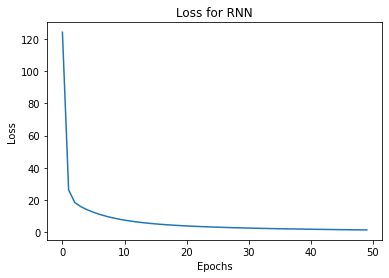

In [11]:
rnn_model = fcRNN(640, 256, 128, 1)
rnn_model.to(device).double()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(rnn_model.parameters(), lr=5e-3)
train_model(rnn_model, train_dataloader, optimizer, loss_function, epochs=50, mode='RNN')

## Training for CNN

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 346.02230785
epoch:   2 loss: 313.97737088
epoch:   3 loss: 254.72645985
epoch:   4 loss: 228.33124567
epoch:   5 loss: 218.40541564
epoch:   6 loss: 196.26764875
epoch:   7 loss: 133.55275446
epoch:   8 loss: 57.32690403
epoch:   9 loss: 28.05814668
epoch:  10 loss: 20.99530643
epoch:  11 loss: 19.50523629
epoch:  12 loss: 18.93354732
epoch:  13 loss: 18.58033094
epoch:  14 loss: 18.29004623
epoch:  15 loss: 18.02454786
epoch:  16 loss: 17.75653619
epoch:  17 loss: 17.47488121
epoch:  18 loss: 17.17450729
epoch:  19 loss: 16.85222538
epoch:  20 loss: 16.50340905
epoch:  21 loss: 16.12788850
epoch:  22 loss: 15.72053674
epoch:  23 loss: 15.27848781
epoch:  24 loss: 14.80311898
epoch:  25 loss: 14.29488530
epoch:  26 loss: 13.75677400
epoch:  27 loss: 13.19903720
epoch:  28 loss: 12.62055508
epoch:  29 loss: 12.04317314
epoch:  30 loss: 11.48759372
epoch:  31 loss: 10.94460550
epoch:  32 loss: 10.42325396
epoch:  33 loss: 9.94902822
epoch:  34 loss: 9.51506550
epoch:  3

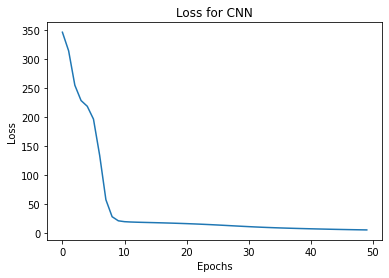

In [12]:
input_size = 5 
model = SimpleCNN(input_size, hidden_dim=256, output_size=NUM_AGENTS*4)
model = model.to(device).double()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)
train_model(model, train_dataloader, optimizer, loss_function, epochs=50, mode='CNN')

In [0]:
## Save model ## 

# CHECKPOINT_PATH = "/content/drive/My Drive/Final Project/Results/Baselines/Models/models_ss_diffIC_best.pth"
# torch.save({'cnn': model,'rnn': rnn_model}, CHECKPOINT_PATH)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SimpleCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type fcRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Evaluation
## Animating + Loading model

This is where we load a pre-trained model stored in the Models folder or just run a model that we just trained

In [0]:
def load_model(path):
  cp = torch.load(path)

  rnn_model = cp['rnn']
  model = cp['cnn']
  return rnn_model, model 

In [0]:
########## Predicting with CNN ##########

#fut_pred = len(pos_test_data)
#fut_pred = len(pos_train_data)-train_window
def evaluate_model(model, extrapolate = False):
  if extrapolate:
    fut_pred = 3000
  else:
    fut_pred = len(pos_data_test)
  # we dont use test_dataloader as we are 'creating' our own test data

  test_inputs = data_train_transform[-TRAIN_WINDOW:].reshape(5, -1)
  model.eval()
  for i  in range(fut_pred):
    idx = TRAIN_WINDOW * i
    seq = torch.FloatTensor(test_inputs[-TRAIN_WINDOW:]).view(1, TRAIN_WINDOW, NUM_AGENTS*4)
    with torch.no_grad():
      out = model(seq.to(device)).detach().cpu().numpy()
      test_inputs = np.concatenate((test_inputs, out.reshape(-1, out.shape[0])), axis=0)

  print(test_inputs.shape)
  # print(test_inputs[5:])
  # only keeps predicted values
  # test_inputs = test_inputs[5:]
  actual_predictions = scaler.inverse_transform(test_inputs)
  # discarding velocity information
  actual_predictions = actual_predictions[:,0:NUM_AGENTS*2]
  actual_predictions = np.reshape(actual_predictions, [len(test_inputs),NUM_AGENTS,2])

  # print('last step: ', np.reshape(pos_data_train[len(pos_data_train)-1], [NUM_AGENTS,2])[0])
  print('prediction: ', actual_predictions[0,0])
  # print('ground truth: ', np.reshape(pos_data_test[0], [NUM_AGENTS,2])[0])
  return actual_predictions

In [0]:
############ REPLAYING FILES ############
def create_replay(actual_predictions, extrapolate, save_name):
  blue_dot = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                            markersize=10, label='Prediction')
  red_dot = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                            markersize=10, label='Ground Truth')
  plt.legend(handles=[blue_dot, red_dot])

  actual_predictions = np.array(actual_predictions)
  pred_len = len(actual_predictions)
  print("Predicted number of time steps: ", pred_len)

  if not extrapolate:
    # ground_truth = np.reshape(pos_data_test, [len(pos_data_test), NUM_AGENTS,2])
    gt = np.concatenate((pos_data_train[-TRAIN_WINDOW:], pos_data_test),axis=0)
    ground_truth = np.reshape(gt,  [pred_len, NUM_AGENTS,2]) 

  x = actual_predictions[:,:,0]
  y = actual_predictions[:,:,1]
  

  x_min = np.amin(x)-2
  x_max = np.amax(x)+2
  y_min = np.amin(y)-2
  y_max = np.amax(y)+2

  mean_x = np.sum(x,axis=1)/NUM_AGENTS
  mean_y = np.sum(y,axis=1)/NUM_AGENTS
  
  if not extrapolate:
    x_gt = ground_truth[:,:,0]
    y_gt = ground_truth[:,:,1]
    mean_x_gt = np.sum(x_gt,axis=1)/NUM_AGENTS
    mean_y_gt = np.sum(y_gt,axis=1)/NUM_AGENTS

  fig = plt.figure()
  fig.set_size_inches(8, 8)
  ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max))

  # initialize animation parameters
  
  if not extrapolate:
    gg = [Line2D([x_gt[0][0], x[0][0]],[y_gt[0][0], y[0][0]]) for i in range(NUM_AGENTS)]
    for j in range(NUM_AGENTS):
      gg[j], = ax.plot([x_gt[0][j], x[0][j]],[y_gt[0][j], y[0][j]], c='mediumspringgreen',marker='.')
    t, = ax.plot(x_gt[0],y_gt[0], c='red',marker='.',linestyle='None')
    t_mean, = ax.plot(mean_x_gt[0],mean_y_gt[0], c='red',marker='+',linestyle='None')

  p, = ax.plot(x[0],y[0], c='blue',marker='.',linestyle='None')
  p_mean, = ax.plot(mean_x[0],mean_y[0], c='blue',marker='+',linestyle='None')

  def animate(i):
      plt.legend(handles=[blue_dot, red_dot])
      if not extrapolate: 
        for j in range(NUM_AGENTS):
          gg[j].set_data([x_gt[i][j], x[i][j]],[y_gt[i][j], y[i][j]])
        t.set_data(x_gt[i],y_gt[i])
        t_mean.set_data(mean_x_gt[i], mean_y_gt[i])

      p.set_data(x[i],y[i])
      p_mean.set_data(mean_x[i], mean_y[i])
      if not extrapolate:
        return p, t, p_mean, t_mean, 
      else:
        return p, p_mean, 

  # call the animator.  blit=True means only re-draw the parts that have changed.
  anim = animation.FuncAnimation(fig, animate, frames=pred_len, interval=20, blit=True)
  anim.save(save_name+'.mp4',writer=animation.FFMpegWriter(fps=20))
  return anim, mean_x, mean_y, mean_x_gt, mean_y_gt


In [0]:
def plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, title):
  x1 = mean_x
  x2 = mean_x_gt
  y1 = mean_y
  y2 = mean_y_gt

  distances = [math.hypot((x1[i]-x2[i]), (y1[i]-y2[i])) for i in range(len(mean_x))]

  plt.figure()
  plt.title(title)  
  plt.xlabel('Samples')
  plt.ylabel('Distance between Predicted and True Mean Field')
  d = 1
  distances_ = [sum(distances[i:i+d])/d for i in range(len(mean_x) - d)]
  plt.plot(distances_)

  return distances

# Running evaluation + Creating animations

If you would like to see the animations in the notebook, create a new cell after running one of the cells below and just enter command:


```
rc('animation', html='jshtml')
anim
```
Note the animations are already available in the google drive folder


# Regular Evaluation

Use the below cell to evaluate a model you just trained

(3005, 128)
prediction:  [5.4619772  6.21214101]
Predicted number of time steps:  3005


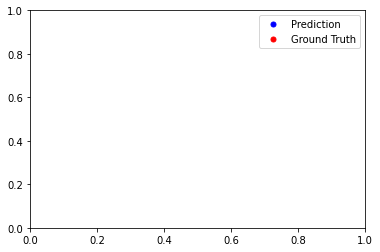

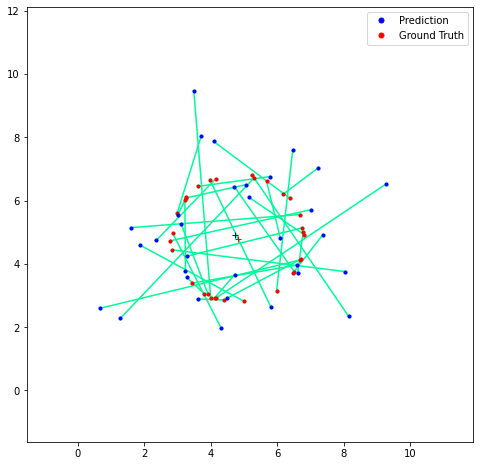

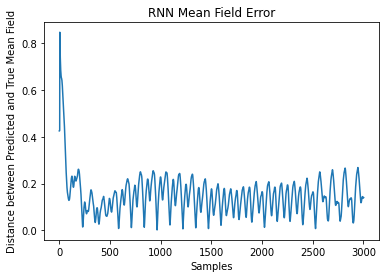

In [17]:
actual_predictions = evaluate_model(rnn_model)
name = 'new_rnn'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'RNN Mean Field Error')

In [18]:
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

(3005, 128)
prediction:  [5.4619772  6.21214101]
Predicted number of time steps:  3005


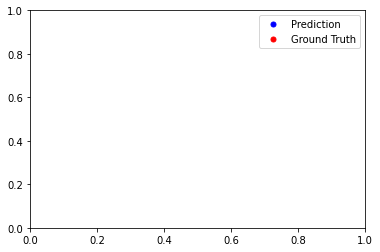

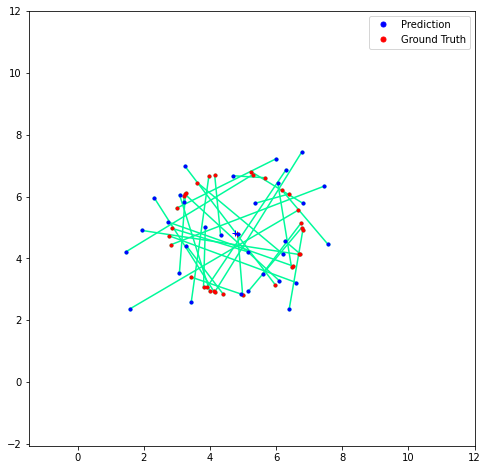

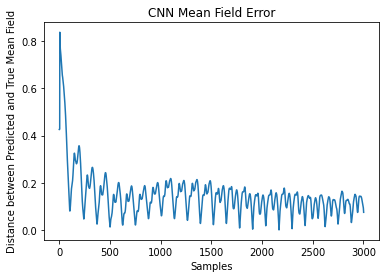

In [19]:
## CNN ##
actual_predictions = evaluate_model(model)
name = 'new_cnn'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'CNN Mean Field Error')

In [20]:
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

# Transient + Differnet IC

*IC is initial Conditions

(3005, 128)
prediction:  [5.80061615 5.31332129]
Predicted number of time steps:  3005


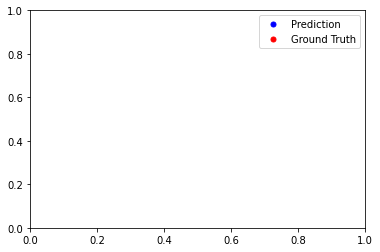

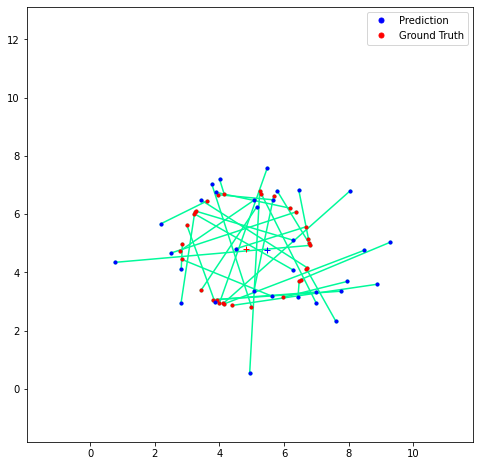

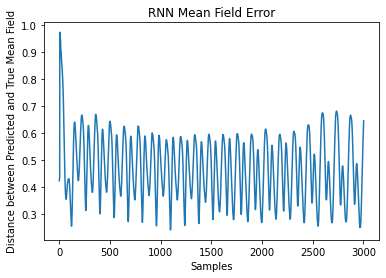

In [0]:
rnn_model, model = load_model('/content/drive/My Drive/Final Project/Results/Baselines/Models/models_transient_diffIC.pth')
actual_predictions = evaluate_model(rnn_model)
name = 'RNN_trans_diffIC'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'RNN Mean Field Error')

(3005, 128)
prediction:  [5.80061615 5.31332129]
Predicted number of time steps:  3005


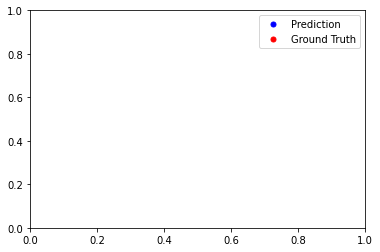

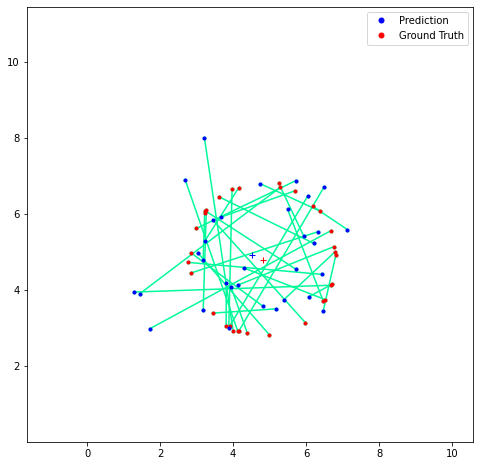

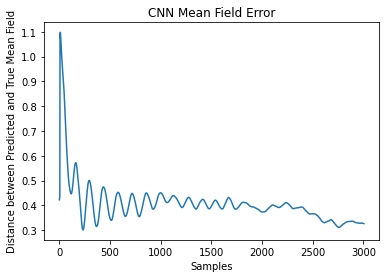

In [0]:
## CNN ##
actual_predictions = evaluate_model(model)
name = 'CNN_trans_diffIC'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'CNN Mean Field Error')

# Steady State + Different IC

In [0]:
rnn_model, model = load_model('/content/drive/My Drive/Final Project/Results/Baselines/Models/models_ss_diffIC_best.pth')
actual_predictions = evaluate_model(rnn_model)
name = 'RNN_trans_diffIC'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)


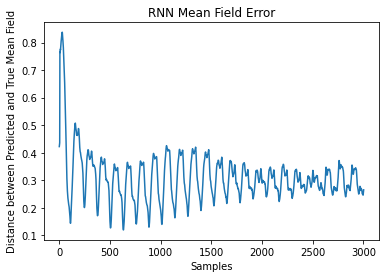

In [0]:
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'RNN Mean Field Error')

(3005, 128)
prediction:  [5.80061615 5.31332129]
Predicted number of time steps:  3005


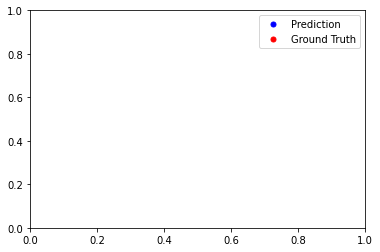

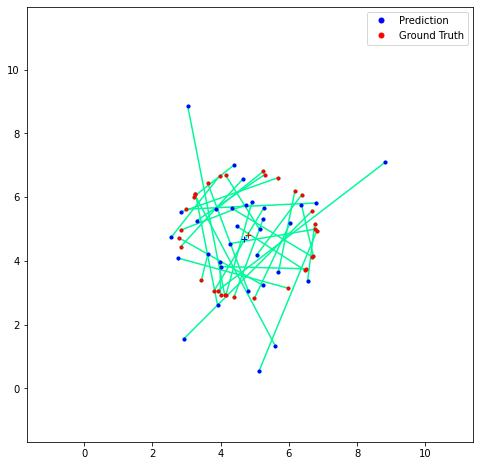

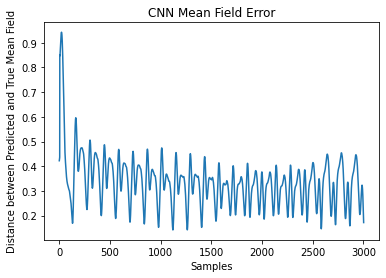

In [0]:
## CNN ##
actual_predictions = evaluate_model(model)
name = 'CNN_trans_diffIC'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'CNN Mean Field Error')

# Tranient + Same IC

(3005, 128)
prediction:  [5.80061615 5.31332129]
Predicted number of time steps:  3005


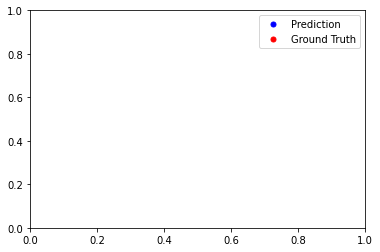

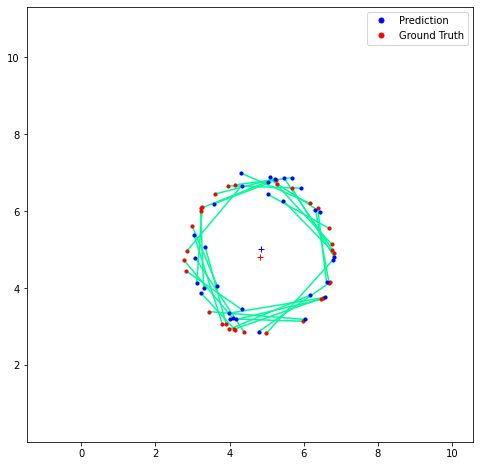

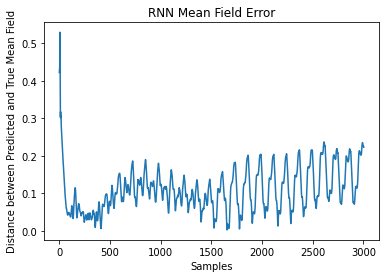

In [0]:
rnn_model, model = load_model('/content/drive/My Drive/Final Project/Results/Baselines/Models/models_transient_sameIC_best.pth')
actual_predictions = evaluate_model(rnn_model)
name = 'RNN_trans_diffIC'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'RNN Mean Field Error')

(3005, 128)
prediction:  [5.80061615 5.31332129]
Predicted number of time steps:  3005


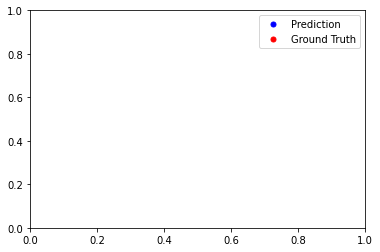

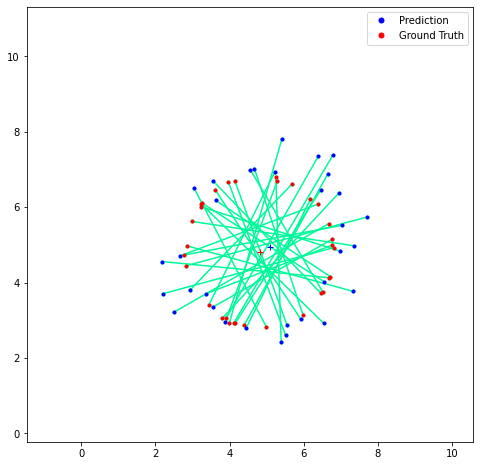

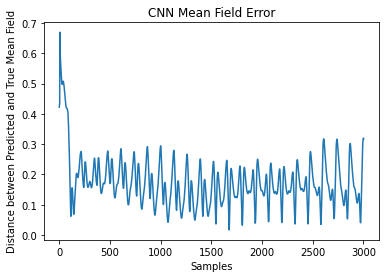

In [0]:
## CNN ##
actual_predictions = evaluate_model(model)
name = 'CNN_trans_diffIC'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'CNN Mean Field Error')

# Steady State + Same IC

(3005, 128)
prediction:  [5.80061615 5.31332129]
Predicted number of time steps:  3005


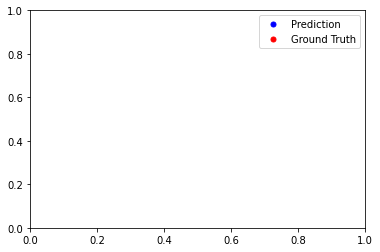

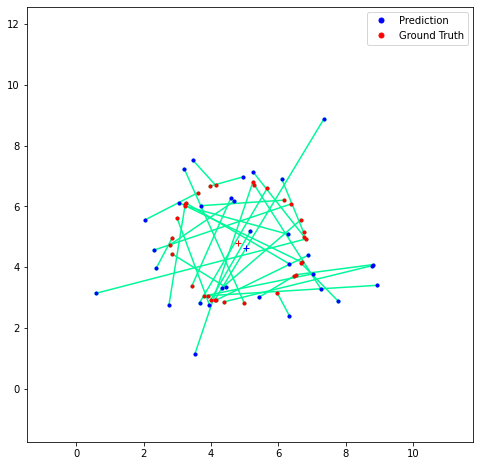

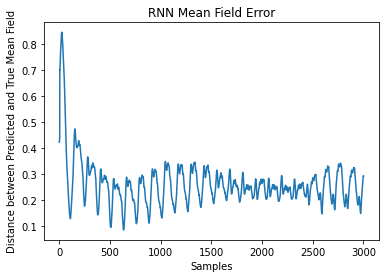

In [0]:
rnn_model, model = load_model('/content/drive/My Drive/Final Project/Results/Baselines/Models/models_ss_sameIC2.pth')
actual_predictions = evaluate_model(rnn_model)
name = 'RNN_ss_sameIC'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'RNN Mean Field Error')

(3005, 128)
prediction:  [5.80061615 5.31332129]
Predicted number of time steps:  3005


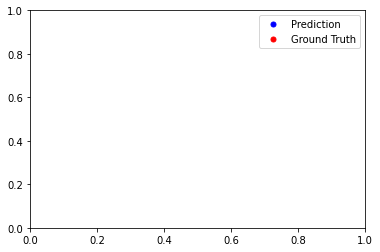

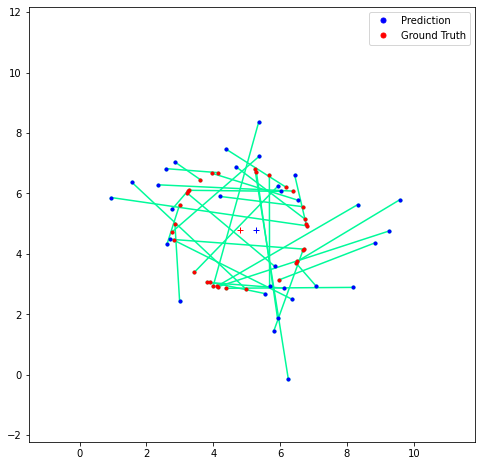

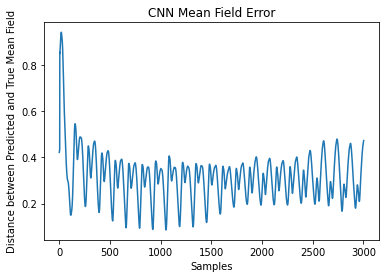

In [0]:
## CNN ##
actual_predictions = evaluate_model(model)
name = 'CNN_ss_sameIC'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'CNN Mean Field Error')

# Steady State + Same IC TRUNCATED

Truncated refers to the removal of the transient state during testing.
This can be done by running the below cell to load the truncated test data

In [0]:
# Perform data mining/manipulation
# We also use a min max scaler to preprocess the data 

## Transient ##

TIMESTEPS = 3000
NUM_AGENTS = 32

(pos_data, vel_data) = split_data(df_ss, 3000, 32)
# Truncate first 500 timesteps 
TRUNC = 300 # first 200-400 steps are transient

# pos_data = pos_data[TRUNC:]
# vel_data = vel_data[TRUNC:]

# Split with min max scaling 
TRAIN_LEN = int(0.4*len(pos_data))
pos_data_train = pos_data[:TRUNC]
vel_data_train = vel_data[:TRUNC]
pos_data_test = pos_data[TRUNC:]
vel_data_test = vel_data[TRUNC:]
data_train = np.concatenate((pos_data_train.reshape(pos_data_train.shape[0], -1), vel_data_train.reshape(vel_data_train.shape[0], -1)), axis = 1)
data_test = np.concatenate((pos_data_test.reshape(pos_data_test.shape[0], -1), vel_data_test.reshape(vel_data_test.shape[0], -1)), axis = 1)  
scaler = MinMaxScaler(feature_range=(-1, 1))
data_train_transform = scaler.fit_transform(data_train.reshape(data_train.shape[0], -1))
data_test_transform = scaler.fit_transform(data_test.reshape(data_test.shape[0], -1))

TRAIN_WINDOW = 5
BATCH_SIZE = 1
train_dataset = SwarmDataset(data_train_transform, training_window=TRAIN_WINDOW)
test_dataset = SwarmDataset(data_test_transform, training_window=TRAIN_WINDOW)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

(2705, 128)
prediction:  [6.41359174 4.68687078]
Predicted number of time steps:  2705


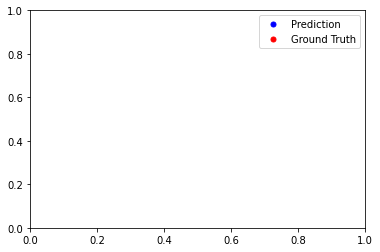

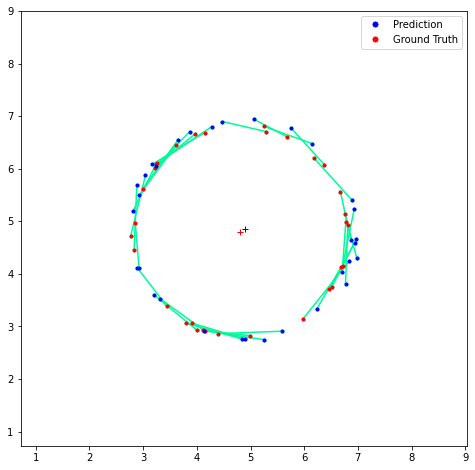

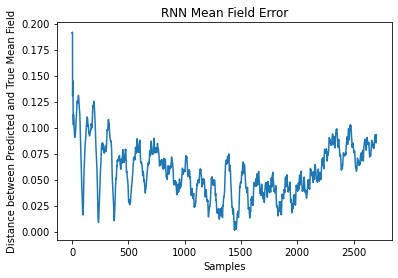

In [0]:
rnn_model, model = load_model('/content/drive/My Drive/Final Project/Results/Baselines/Models/models_ss_sameIC_best.pth')
actual_predictions = evaluate_model(rnn_model)
name = 'RNN_'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'RNN Mean Field Error')

(2705, 128)
prediction:  [6.41359174 4.68687078]
Predicted number of time steps:  2705


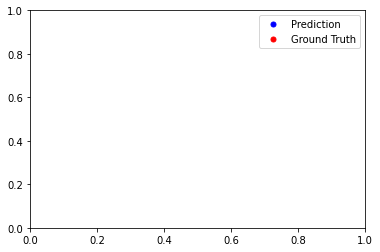

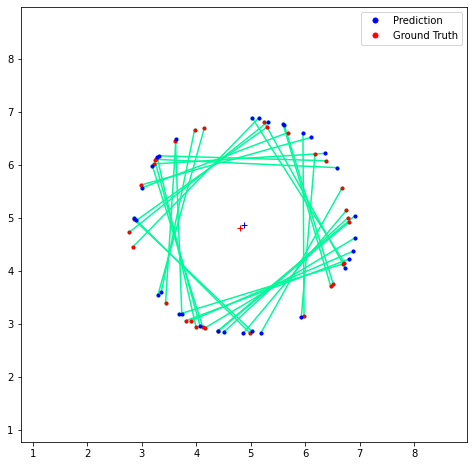

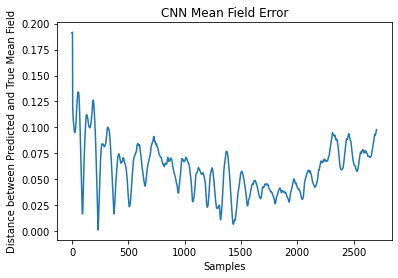

In [0]:
actual_predictions = evaluate_model(model)
name = 'CNN_'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'CNN Mean Field Error')

# Transient State + Same IC TRUNCATED

(2705, 128)
prediction:  [6.41359174 4.68687078]
Predicted number of time steps:  2705


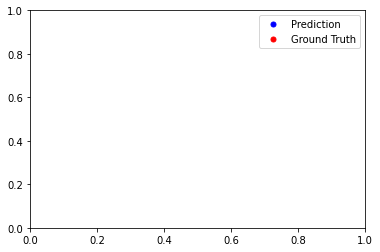

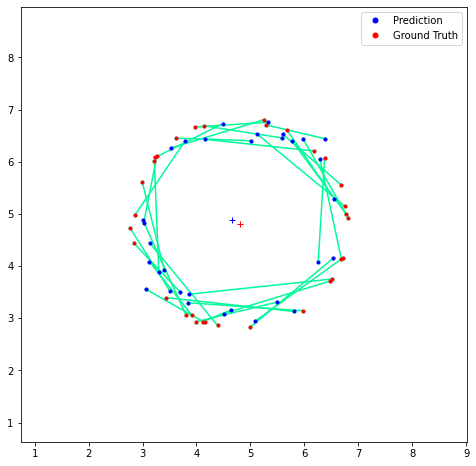

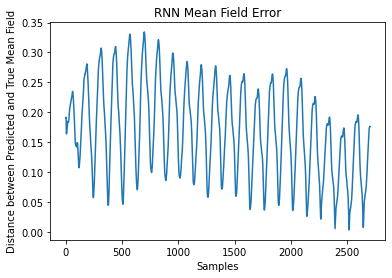

In [0]:
rnn_model, model = load_model('/content/drive/My Drive/Final Project/Results/Baselines/Models/models_transient_sameIC_best.pth')
actual_predictions = evaluate_model(rnn_model)
name = 'RNN_'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'RNN Mean Field Error')

(2705, 128)
prediction:  [6.41359174 4.68687078]
Predicted number of time steps:  2705


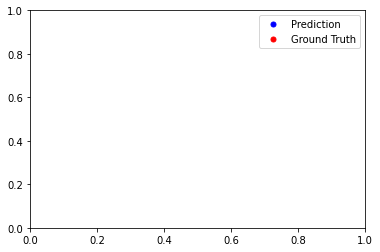

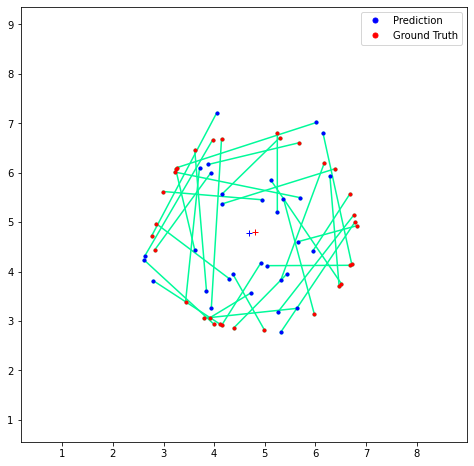

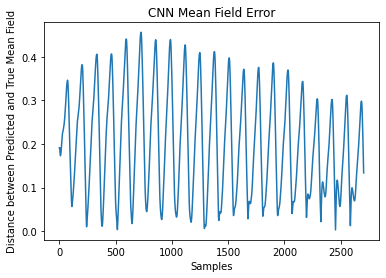

In [0]:
actual_predictions = evaluate_model(model)
name = 'CNN_'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'CNN Mean Field Error')

# Steady State + Diff IC TRUNCATED

(2705, 128)
prediction:  [6.41359174 4.68687078]
Predicted number of time steps:  2705


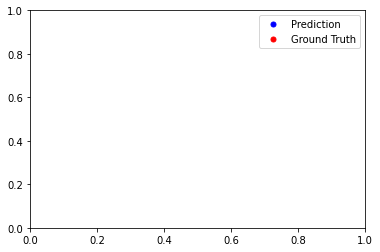

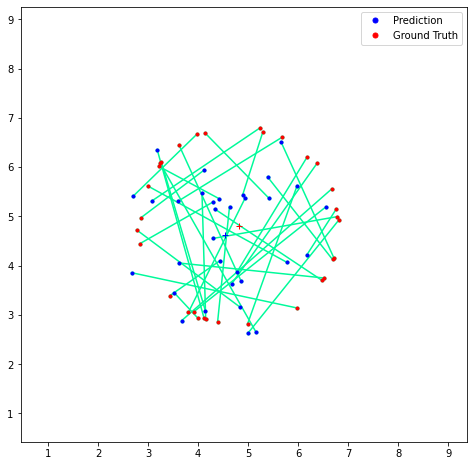

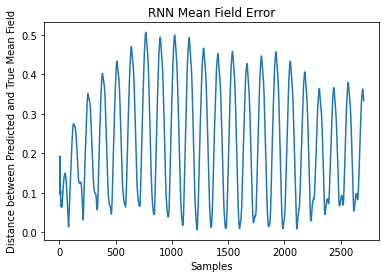

In [0]:
rnn_model, model = load_model('/content/drive/My Drive/Final Project/Results/Baselines/Models/models_ss_diffIC_best.pth')
actual_predictions = evaluate_model(rnn_model)
name = 'RNN_'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'RNN Mean Field Error')

(2705, 128)
prediction:  [6.41359174 4.68687078]
Predicted number of time steps:  2705


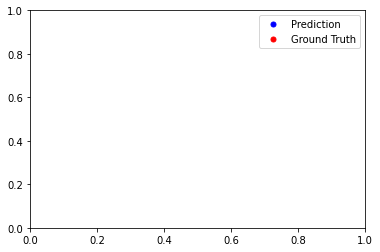

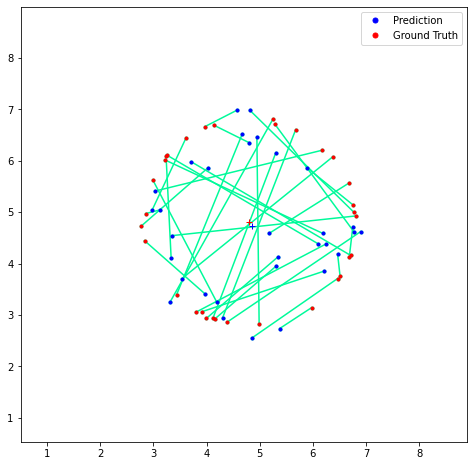

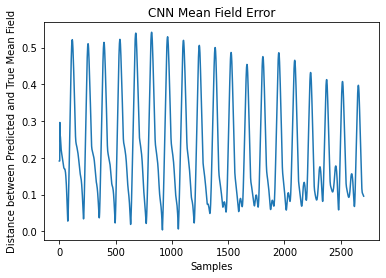

In [0]:
actual_predictions = evaluate_model(model)
name = 'CNN_'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'CNN Mean Field Error')

# Transient + Diff IC TRUNCATED

(2705, 128)
prediction:  [6.41359174 4.68687078]
Predicted number of time steps:  2705


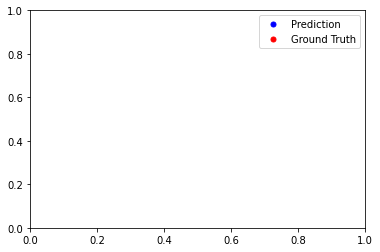

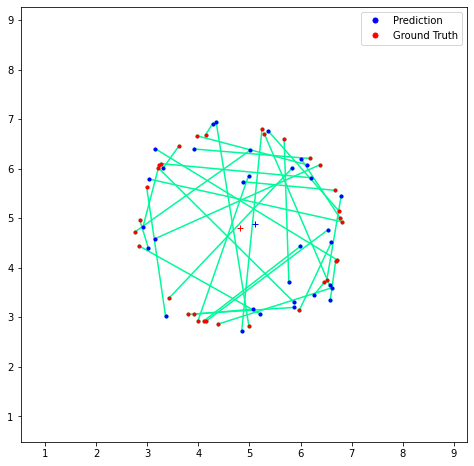

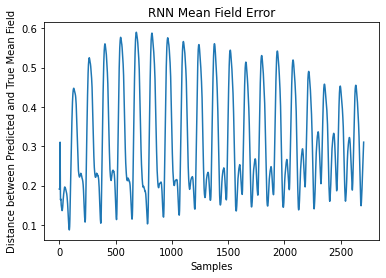

In [0]:
rnn_model, model = load_model('/content/drive/My Drive/Final Project/Results/Baselines/Models/models_transient_diffIC.pth')
actual_predictions = evaluate_model(rnn_model)
name = 'RNN_'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'RNN Mean Field Error')

(2705, 128)
prediction:  [6.41359174 4.68687078]
Predicted number of time steps:  2705


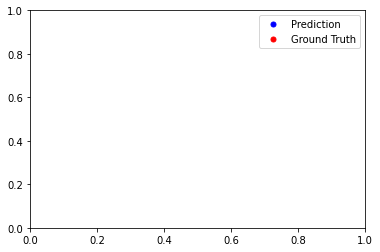

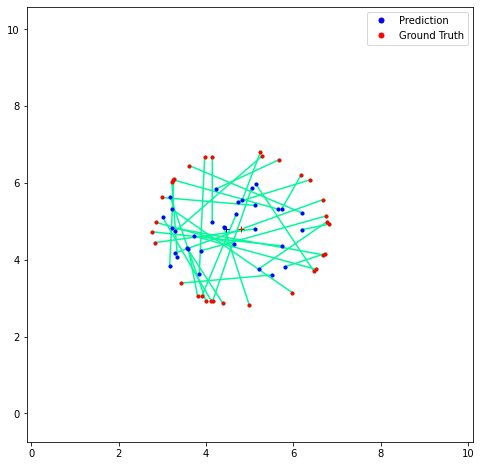

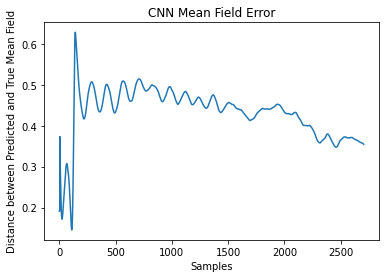

In [0]:
actual_predictions = evaluate_model(model)
name = 'CNN_'
anim, mean_x, mean_y, mean_x_gt, mean_y_gt = create_replay(actual_predictions, False, name)
d = plot_mean_field_errors(mean_x, mean_x_gt, mean_y, mean_y_gt, 'CNN Mean Field Error')

# Miscellaneous Code

In [0]:
def calculate_POD_basis(snapshots):
    '''
    :param snapshots: snapshots imported as 2-D array of size (# of elements, # of snapshots)

    :return:
    '''
    n_time = len(snapshots)
    snapshots = np.transpose(snapshots)
    # singular value decomposition
    U,S,V = np.linalg.svd(snapshots)

    U = U.real
    S = S.real
    V = V.real

    I = np.argsort(S)[::-1]
    S = S[I]
    U = U[:, I]
    '''
    pod_basis = create_basis(U, S, energy=0.65)
    
    '''
    pod_basis = U[:,0:2]
    pod_basis = np.reshape(pod_basis, [-1,pod_basis.shape[1]])
    

    _,m = pod_basis.shape
    print('pod basis shape: ', pod_basis.shape, 'm: ',m)
    sing = np.diag(S[0:m])
    tail = np.zeros([m,n_time-m])
    mid = np.concatenate((sing, tail), axis=1)
    
    recon = pod_basis @ mid @ V
    return U, S, V, np.transpose(recon)


def create_basis(V, D, energy):
    '''
    Creates basis functions for POD using SVD decomposition
    :param V: eigenvectors of covariance matrix
    :param D: diagonal matrix with eigenvalues of covariance matrix
    :param energy: parameter for how much "energy" is desired to be capture in POD basis (usually 95%+)
    :return: POD basis phi
    '''
    cum_sum = 0
    total_sum = sum(D).real
    m = 0  # Calculate number of POD bases that will be needed

    for i in range(len(D)):
        cum_sum += D[i].real
        percentage_energy = cum_sum/total_sum
        if percentage_energy < energy:
            m = i
        else:
            m = i
            break

    # Create new matrix based on POD values at each of the sub domains given by value in regionDictionary
    # phi is (n, m) for n = number of elements in mesh, m = number of elements in POD
    phi = V[:, 0:m + 1]
    return phi.real


pod basis shape:  (64, 2) m:  2


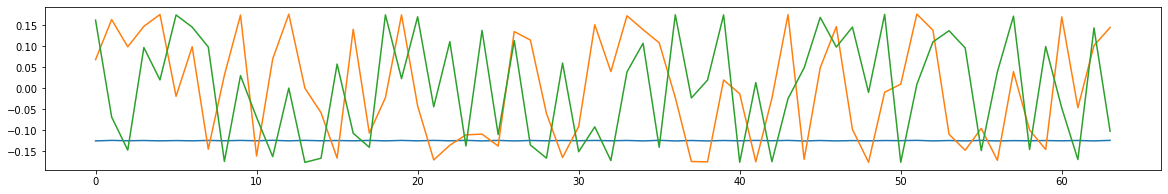

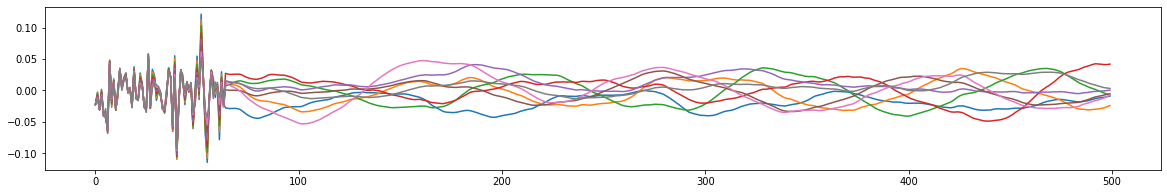

In [0]:
U,S,V,gt_recon = calculate_POD_basis(gt)
'''
pred_recon = calculate_POD_basis(np.reshape(actual_predictions, [len(actual_predictions), -1]))

gt_recon = np.reshape(np.array(gt_recon), [len(gt),-1,2])
pred_recon = np.reshape(np.array(pred_recon), [len(gt),-1,2])
'''
#plt.plot(S, marker ='.',linestyle="None")
fig = plt.figure()
fig.set_size_inches(20, 3)
plt.plot(U[:,0])
plt.plot(U[:,1])
plt.plot(U[:,2])
#plt.plot(U[:,63])
fig = plt.figure()
fig.set_size_inches(20, 3)
plt.plot(V[0:500,0])
plt.plot(V[0:500,1])
plt.plot(V[0:500,2])
plt.plot(V[0:500,3])
plt.plot(V[0:500,4])
plt.plot(V[0:500,5])
plt.plot(V[0:500,6])
plt.plot(V[0:500,7])
